#### TOC:
* Training a deep learning network
    * List number of layers and parameters used in your architecture.
* The confusion matrix, the top-1 and top-3 accuracy of your training result.
* Calculate the value of $$\frac{𝑡𝑜𝑝−1 \ 𝑎𝑐𝑐𝑢𝑟𝑎𝑐𝑦}{num \ 𝑜𝑓 \  𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟}$$
* Predict on Test data and store the result in csv.

##### Training a deep learning network

determine training device

In [ ]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Read .txt file context and store in dataframe

In [ ]:
import os 
import pandas as pd

file_path = './HW2_MNIST_train/'

# 讀取所有 txt 檔案，建立 DataFrame
data_list = []
for txt_file in os.listdir(file_path):
    if txt_file.endswith(".txt"):
        img_name = txt_file.replace(".txt", ".png")  
        img_path = os.path.join(file_path, img_name)
        txt_path = os.path.join(file_path, txt_file)
        
        with open(txt_path, "r") as f:
            label = f.read().strip().split('\t')  # 讀取標籤
            label.insert(0, img_path)
            data_list.append(label)
        

# 轉成 DataFrame
df = pd.DataFrame(data_list, columns=["img_path", "label", "upper_left_x", "upper_left_y", "h", "w"])

In [296]:
print(df.head())

                        img_path label upper_left_x upper_left_y        h  \
0  ./HW2_MNIST_train/0000000.png     0    0.3671875    0.3203125  0.21875   
1  ./HW2_MNIST_train/0000001.png     0    0.5390625      0.53125   0.4375   
2  ./HW2_MNIST_train/0000002.png     0    0.7734375    0.4296875  0.21875   
3  ./HW2_MNIST_train/0000003.png     0     0.515625    0.2421875   0.4375   
4  ./HW2_MNIST_train/0000005.png     0    0.2890625          0.5   0.4375   

         w  
0  0.21875  
1   0.4375  
2  0.21875  
3   0.4375  
4   0.4375  


useful function that can move digit into center

In [250]:
import cv2
import numpy as np

def move_bounding_box_to_center(image, bbox):
    """
    將已知 Bounding Box 的數字移動到圖片中央
    :param image: 原始圖片 (numpy array)
    :param bbox: Bounding Box (x, y, w, h)
    :return: 平移後的圖片
    """
    h, w = image.shape[:2]  # 取得圖片的高和寬
    new_bbox = int(bbox[0]*w), int(bbox[1]*h), int(bbox[2]*w), int(bbox[3]*h)  # 座標轉換
    x, y, bw, bh = bbox  # Bounding Box 的 x, y, width, height

    # 計算 Bounding Box 的中心點
    bbox_center_x = x + bw // 2
    bbox_center_y = y + bh // 2

    # 計算整張圖片的中心點
    img_center_x = w // 2
    img_center_y = h // 2

    # 計算平移量 (dx, dy)
    dx = img_center_x - bbox_center_x
    dy = img_center_y - bbox_center_y

    # 建立平移矩陣
    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])

    # 進行平移
    translated_image = cv2.warpAffine(image, translation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    return translated_image

# 測試
image = cv2.imread("./HW2_MNIST_train/0000002.png", cv2.IMREAD_GRAYSCALE)  # 讀取灰階圖片
bounding_box = (int(0.7734375 * image.shape[1]), int(0.4296875 * image.shape[0]), int(0.21875 * image.shape[1]), int(0.21875 * image.shape[0]))  # 假設已知的 Bounding Box (x, y, w, h)
centered_image = move_bounding_box_to_center(image, bounding_box)

# 顯示結果
# cv2.imshow("Centered Image", centered_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


pytorch dataset

In [308]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 定義 PyTorch Dataset
class ImageDataset(Dataset):
    # fetch information form the dataframe and transform the image
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.dataframe.iloc[idx, 1])

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # grayscale
        h, w = image.shape[:2]
        # get the bounding box
        bbox = (
            float(self.dataframe.iloc[idx, 2]),
            float(self.dataframe.iloc[idx, 3]),
            float(self.dataframe.iloc[idx, 4]),
            float(self.dataframe.iloc[idx, 5])
        )
        # image = move_bounding_box_to_center(image, bbox)

        # convert to PIL image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# 定義transform
transform = transforms.Compose([
    transforms.ToTensor(),           # a kind of normalization and transform to tensor
    transforms.Normalize((0.5,), (0.5,)),  # normalize the image
])

In [275]:
# know each label's distribution
print(df['label'].value_counts())

label
1    10835
0    10785
7    10007
3     9812
2     9531
9     9524
6     9474
8     9427
4     9314
5     8687
Name: count, dtype: int64


In [330]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation sets with stratification to ensure even label distribution
train_df, val_df = train_test_split(df, test_size=0.3, random_state=3, stratify=df['label'])

# Define the batch size
batch_size = 8

# create dataset and dataloader
train_dset = ImageDataset(dataframe=train_df, transform=transform)
train_dataloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
val_dset = ImageDataset(dataframe=val_df, transform=transform)
val_dataloader = DataLoader(val_dset, batch_size=batch_size, shuffle=False)

# 測試資料加載
for images, labels in train_dataloader:
    print(images.shape)  # 輸出: (batch_size, channels, height, width)
    print(labels.shape)  # 輸出: (batch_size,)
    break

torch.Size([8, 1, 128, 128])
torch.Size([8])


build model

In [323]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(1, 128, 128)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1), # (8,124,124)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (8,62,62)
            nn.Conv2d(8, 8, kernel_size=3, stride=1), # (8,60,60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (8,30,30)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=5, stride=1), # (32,26,26)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), # (32,24,24)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # (32,12,12)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1), # (64,10,10)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # (64,8,8)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (64,4,4)
        )
        
        # Fully connected 1
        self.fc1 = nn.Linear(64*4*4, 64) 
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # Resize
        out = out.view(out.size(0), -1) # (batch_size, 128*10*10)
        # Linear function (readout)
        out = self.fc1(out) # (batch_size, 10)
        out = self.fc2(out)
        return out

###### List number of layers and parameters used in your architecture.

In [324]:
import torchinfo

model = CNN_Model().to(device)
print(f"Model's structure:\n {torchinfo.summary(model)}")

Model's structure:
Layer (type:depth-idx)                   Param #
CNN_Model                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       208
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       584
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-7                       6,432
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       9,248
│    └─ReLU: 2-10                        --
│    └─MaxPool2d: 2-11                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-12                      18,496
│    └─ReLU: 2-13                        --
│    └─Conv2d: 2-14                      36,928
│    └─ReLU: 2-15                        --
│    └─MaxPool2d: 2-16                   --
├─Linear: 1-4                       

training progress

In [331]:
from matplotlib import pyplot as plt
Epoch = 5

# loss function
loss = nn.CrossEntropyLoss()
# optimizer and learning rate
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
valid_loss_values = []
train_accuracy_values = []
valid_accuracy_values = []
best_val_acc = 0

for epoch in range(1, Epoch+1):
    model.train()
    accuracy = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        # move data to device
        X_train = images.to(device)
        Y_train = labels.to(device).long()

        # zero gradients
        optimizer.zero_grad()
        # forward pass
        Y_pred = model(X_train)
        # compute loss
        l = loss(Y_pred, Y_train)
        # backward pass
        l.backward()
        # update weights
        optimizer.step()
        # calculate accuracy
        predictions = Y_pred.argmax(dim=1)  # Get the predicted class index
        accuracy += (predictions == Y_train).sum().item()
        # update the training "total" loss
        train_loss += (l.item() * Y_train.size(0))  # accumulate loss
        # print the loss and accuracy for every batch
        # print every batch_size batches
        print(f"In Epoch {epoch}: Batch {(i+1)*batch_size}/{len(train_dataloader.dataset)}: Loss: {l.item():.4f}, Accuracy: {(predictions == Y_train).sum().item()/Y_train.size(0):.4f}")
        
    # average the loss and accuracy
    accuracy /= len(train_dataloader.dataset)
    train_loss /= len(train_dataloader.dataset)
    print(f"Epoch {epoch}: Accuracy: {accuracy:.4f}, Train Loss: {train_loss:.4f}")

    # store the loss and accuracy
    loss_values.append(train_loss)
    train_accuracy_values.append(accuracy)

    # evaluate the model
    model.eval()
    valid_acc = 0.0
    valid_loss = 0.0
    # iterate through the validation set
    for images, labels in val_dataloader:
        # move data to device
        X_test = images.to(device)
        Y_test = labels.to(device).long()

        Y_pred = model(X_test)
        # compute loss
        l = loss(Y_pred, Y_test)
        # calculate accuracy
        predictions = Y_pred.argmax(dim=1)  # Get the predicted class index
        valid_acc += (predictions == Y_test).sum().item()
        # update the validation "total" loss
        valid_loss += l.item() * X_test.size(0)  # accumulate loss
        
    # store the loss and accuracy
    valid_acc /= len(val_dataloader.dataset)
    valid_loss /= len(val_dataloader.dataset)
    valid_loss_values.append(valid_loss)
    valid_accuracy_values.append(valid_acc)
    
    if best_val_acc < valid_acc:
        # update the best validation accuracy
        best_val_acc = valid_acc
        # save the model if the validation loss is the best so far
        torch.save(model.state_dict(), 'model.pth')

    # print the loss and accuracy for every 5 epochs
    print(f"Epoch {epoch}: Validation Accuracy: {valid_acc:.4f}, Validation Loss: {valid_loss:.4f}")

In Epoch 1: Batch 8/68177: Loss: 2.0691, Accuracy: 0.1250
In Epoch 1: Batch 16/68177: Loss: 2.1571, Accuracy: 0.2500
In Epoch 1: Batch 24/68177: Loss: 1.9373, Accuracy: 0.2500
In Epoch 1: Batch 32/68177: Loss: 2.1589, Accuracy: 0.2500
In Epoch 1: Batch 40/68177: Loss: 2.0846, Accuracy: 0.1250
In Epoch 1: Batch 48/68177: Loss: 2.0985, Accuracy: 0.2500
In Epoch 1: Batch 56/68177: Loss: 1.8642, Accuracy: 0.1250
In Epoch 1: Batch 64/68177: Loss: 2.0563, Accuracy: 0.1250
In Epoch 1: Batch 72/68177: Loss: 1.8791, Accuracy: 0.3750
In Epoch 1: Batch 80/68177: Loss: 2.0818, Accuracy: 0.2500
In Epoch 1: Batch 88/68177: Loss: 2.1126, Accuracy: 0.3750
In Epoch 1: Batch 96/68177: Loss: 2.0703, Accuracy: 0.1250
In Epoch 1: Batch 104/68177: Loss: 1.7812, Accuracy: 0.3750
In Epoch 1: Batch 112/68177: Loss: 1.8195, Accuracy: 0.3750
In Epoch 1: Batch 120/68177: Loss: 2.1124, Accuracy: 0.1250
In Epoch 1: Batch 128/68177: Loss: 2.1829, Accuracy: 0.1250
In Epoch 1: Batch 136/68177: Loss: 1.5599, Accuracy: 

show loss variation and accuracy variation

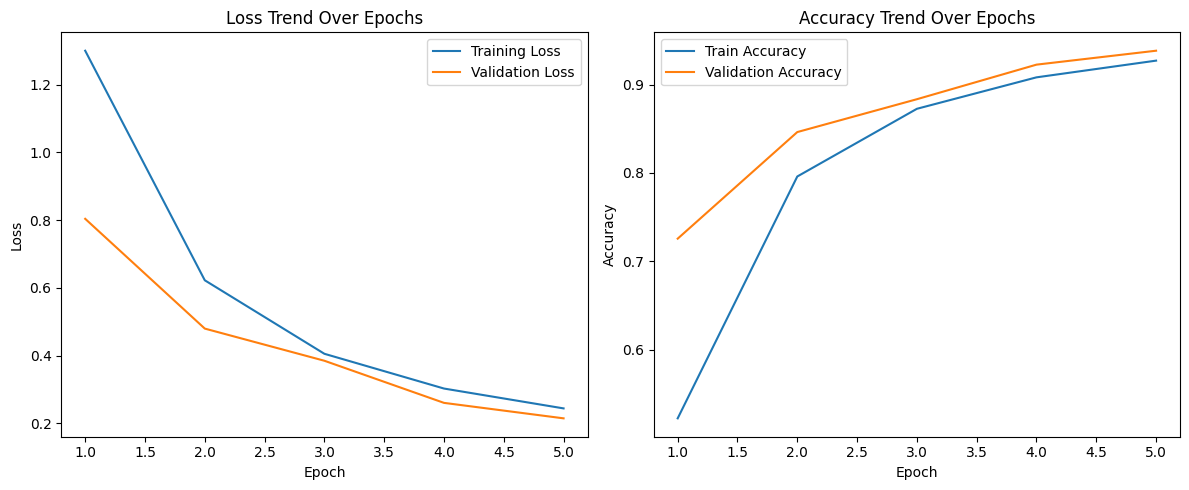

In [332]:
# plot the loss and accuracy trends
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot the loss trend
ax[0].plot(range(1, Epoch+1), loss_values, label='Training Loss')
ax[0].plot(range(1, Epoch+1), valid_loss_values, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Trend Over Epochs')
ax[0].legend()

# plot the accuracy trend
ax[1].plot(range(1, Epoch+1), train_accuracy_values, label='Train Accuracy')
ax[1].plot(range(1, Epoch+1), valid_accuracy_values, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Trend Over Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

Little annotation: `Small batch size` can help model to learn feature better.

##### The confusion matrix, the top-1 and top-3 accuracy of your training result.

Testing progress
To calculte topk accuacy and confusion matrix, testing the current model on training dataset

In [ ]:
# 加載模型
model = CNN_Model().to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [375]:
# 計算topk 跟 confusion matrix 用的
test_df = df

In [376]:
print(len(test_df))
test_df.head()

97396


img_path label upper_left_x upper_left_y        h  \
0  ./HW2_MNIST_train/0000000.png     0    0.3671875    0.3203125  0.21875   
1  ./HW2_MNIST_train/0000001.png     0    0.5390625      0.53125   0.4375   
2  ./HW2_MNIST_train/0000002.png     0    0.7734375    0.4296875  0.21875   
3  ./HW2_MNIST_train/0000003.png     0     0.515625    0.2421875   0.4375   
4  ./HW2_MNIST_train/0000005.png     0    0.2890625          0.5   0.4375   

         w  
0  0.21875  
1   0.4375  
2  0.21875  
3   0.4375  
4   0.4375

In [377]:
test_dst = ImageDataset(dataframe=test_df, transform=transform)
test_loader = DataLoader(test_dst, batch_size=batch_size, shuffle=False)

Top-1 Accuracy and Confusion Matrix

In [378]:
correct = 0
total = 0
# 新增這邊記錄真實跟預測值
pred_list = []
label_list = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        # move data to device
        X_test = images.to(device)
        Y_test = labels.to(device).long()

        # calculate outputs by running images through the network
        outputs = model(X_test)
        
        # get corresponding predicted labels
        predictions = outputs.argmax(dim=1)  # Get the predicted class index
        
        # calculate accuracy
        correct += (predictions == Y_test).sum().item()

        # store the predictions and labels
        pred_list.extend(predictions.cpu().numpy())
        label_list.extend(Y_test.cpu().numpy())
        
        # print the loss and accuracy for every batch
        print(f"Batch {(i+1)*batch_size}/{len(test_loader.dataset)}: Accuracy: {(predictions == Y_test).sum().item()/Y_test.size(0):.4f}")

top1_acc = correct / len(test_loader.dataset)
print("Top 1 Accuracy on test data: ", top1_acc)   

Batch 8/97396: Accuracy: 0.8750
Batch 16/97396: Accuracy: 1.0000
Batch 24/97396: Accuracy: 1.0000
Batch 32/97396: Accuracy: 1.0000
Batch 40/97396: Accuracy: 1.0000
Batch 48/97396: Accuracy: 1.0000
Batch 56/97396: Accuracy: 1.0000
Batch 64/97396: Accuracy: 1.0000
Batch 72/97396: Accuracy: 1.0000
Batch 80/97396: Accuracy: 1.0000
Batch 88/97396: Accuracy: 1.0000
Batch 96/97396: Accuracy: 1.0000
Batch 104/97396: Accuracy: 0.8750
Batch 112/97396: Accuracy: 1.0000
Batch 120/97396: Accuracy: 1.0000
Batch 128/97396: Accuracy: 0.8750
Batch 136/97396: Accuracy: 1.0000
Batch 144/97396: Accuracy: 1.0000
Batch 152/97396: Accuracy: 1.0000
Batch 160/97396: Accuracy: 1.0000
Batch 168/97396: Accuracy: 1.0000
Batch 176/97396: Accuracy: 1.0000
Batch 184/97396: Accuracy: 0.7500
Batch 192/97396: Accuracy: 1.0000
Batch 200/97396: Accuracy: 0.8750
Batch 208/97396: Accuracy: 1.0000
Batch 216/97396: Accuracy: 1.0000
Batch 224/97396: Accuracy: 0.8750
Batch 232/97396: Accuracy: 0.8750
Batch 240/97396: Accuracy: 

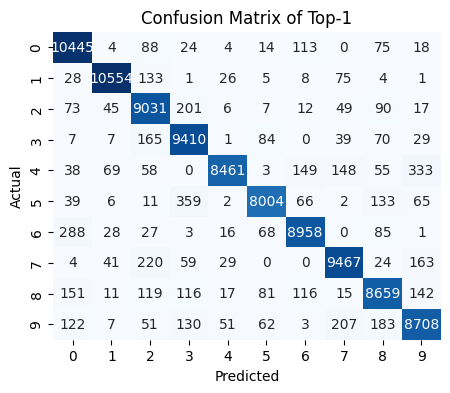

In [379]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

pred_list = np.array(pred_list)
label_list = np.array(label_list)

cm = confusion_matrix(y_true=label_list, y_pred=pred_list)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix of Top-1')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Top-3 Accuracy and Confusion matrix  
Note: when drawing confusion matrix, first check if there is true_label exists in top_3 list. Otherwise, selecting the most probable label (that is top-1) as the predicted_label.

In [380]:

# 計算 Top-3 Accuracy
correct_top3 = 0
pred_list_top3 = []
label_list_top3 = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        # move data to device
        X_test = images.to(device)
        Y_test = labels.to(device).long()

        # calculate outputs by running images through the network
        outputs = model(X_test)
        
        # get corresponding predicted labels
        _, top3_predictions = outputs.topk(3, dim=1)  # Get the top-3 predicted class indices
        
        # calculate top-3 accuracy
        # check if the true label is in the top-3 predictions list
        count = sum([Y_test[i].item() in top3_predictions[i].tolist() for i in range(len(Y_test))])
        correct_top3 += count

        # store the predictions and labels for confusion matrix
        pred_list_top3.extend(top3_predictions.cpu().numpy())
        label_list_top3.extend(Y_test.cpu().numpy())

        # print the top-3 accuracy for every batch
        print(f"Batch {(i+1)*batch_size}/{len(test_loader.dataset)}: Top-3 Accuracy: {count / (batch_size):.4f}")

    # calculate and print the overall top-3 accuracy
    print("Top-3 Accuracy on test data: ", correct_top3 / len(test_loader.dataset))

Batch 8/97396: Top-3 Accuracy: 1.0000
Batch 16/97396: Top-3 Accuracy: 1.0000
Batch 24/97396: Top-3 Accuracy: 1.0000
Batch 32/97396: Top-3 Accuracy: 1.0000
Batch 40/97396: Top-3 Accuracy: 1.0000
Batch 48/97396: Top-3 Accuracy: 1.0000
Batch 56/97396: Top-3 Accuracy: 1.0000
Batch 64/97396: Top-3 Accuracy: 1.0000
Batch 72/97396: Top-3 Accuracy: 1.0000
Batch 80/97396: Top-3 Accuracy: 1.0000
Batch 88/97396: Top-3 Accuracy: 1.0000
Batch 96/97396: Top-3 Accuracy: 1.0000
Batch 104/97396: Top-3 Accuracy: 1.0000
Batch 112/97396: Top-3 Accuracy: 1.0000
Batch 120/97396: Top-3 Accuracy: 1.0000
Batch 128/97396: Top-3 Accuracy: 1.0000
Batch 136/97396: Top-3 Accuracy: 1.0000
Batch 144/97396: Top-3 Accuracy: 1.0000
Batch 152/97396: Top-3 Accuracy: 1.0000
Batch 160/97396: Top-3 Accuracy: 1.0000
Batch 168/97396: Top-3 Accuracy: 1.0000
Batch 176/97396: Top-3 Accuracy: 1.0000
Batch 184/97396: Top-3 Accuracy: 1.0000
Batch 192/97396: Top-3 Accuracy: 1.0000
Batch 200/97396: Top-3 Accuracy: 0.8750
Batch 208/973

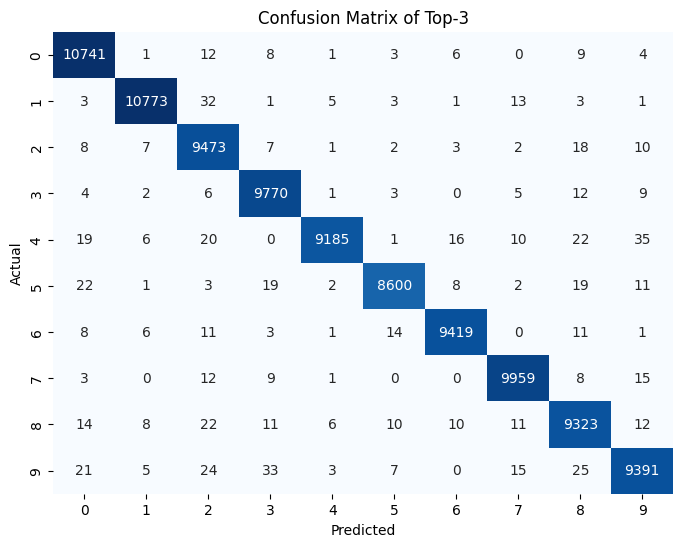

In [381]:
# 將 pred_list_top3 和 label_list_top3 轉換為 numpy array
pred_list_top3 = np.array(pred_list_top3)
label_list_top3 = np.array(label_list_top3)


pred_yes = []
# 手動計算 Top-3 Confusion Matrix
for true_label, top3_preds in zip(label_list_top3, pred_list_top3):
    if true_label in top3_preds:
        pred_yes.append(true_label) # 如果真實標籤在前3名預測中，則將其添加到 pred_yes
    else:
        pred_yes.append(top3_preds[0]) # 不然取top3預測出最有可能的那個當作預測標籤

cm_top3 = confusion_matrix(y_true=label_list, y_pred=pred_yes)

# 繪製 Top-3 Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_top3, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix of Top-3')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

##### Calculate the value of $$\frac{𝑡𝑜𝑝−1 \ 𝑎𝑐𝑐𝑢𝑟𝑎𝑐𝑦}{num \ 𝑜𝑓 \  𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟}$$.

In [385]:
top1_accuracy = top1_acc  # calculated earlier
print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
total_params = sum(p.numel() for p in model.parameters())
print(f"模型的總參數數量: {total_params}") # 138,146

print(f'top-1 accuracy/ num of parameters: {top1_accuracy / total_params}')

Top-1 Accuracy: 0.9415
模型的總參數數量: 138146
top-1 accuracy/ num of parameters: 6.8151542812600155e-06


##### Predict on test data and store the result in csv.

read test dataset

In [387]:
file_path = './HW2_MNIST_test/'

# test data only contains png files
img = []
for png_file in os.listdir(file_path):
    img.append(png_file)

# 轉成 DataFrame
df_test = pd.DataFrame(img, columns=["img_path"])

In [397]:
print(f'length = {len(df_test)}')
df_test.head()

length = 24350


img_path
0  0000004.png
1  0000010.png
2  0000018.png
3  0000021.png
4  0000027.png

Predict on Test data

In [398]:
# store the results
result = []

for idx in range(len(df_test)):
    img_path = df_test.iloc[idx, 0]
    print(f"current processing image {idx}, name = {img_path}")
    img_path = os.path.join(file_path, img_path)
    
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 讀取灰階圖片
    # 不做 bounding box 平移
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0).to(device)  # add batch dimension and move to device

    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).item()  # Get the predicted class index
        result.append(prediction)
    
# 將結果轉換為 DataFrame
result_df = pd.DataFrame({'image': df_test['img_path'], 'class': result})

current processing image 0, name = 0000004.png
current processing image 1, name = 0000010.png
current processing image 2, name = 0000018.png
current processing image 3, name = 0000021.png
current processing image 4, name = 0000027.png
current processing image 5, name = 0000038.png
current processing image 6, name = 0000040.png
current processing image 7, name = 0000041.png
current processing image 8, name = 0000042.png
current processing image 9, name = 0000055.png
current processing image 10, name = 0000057.png
current processing image 11, name = 0000058.png
current processing image 12, name = 0000059.png
current processing image 13, name = 0000062.png
current processing image 14, name = 0000064.png
current processing image 15, name = 0000065.png
current processing image 16, name = 0000066.png
current processing image 17, name = 0000069.png
current processing image 18, name = 0000071.png
current processing image 19, name = 0000072.png
current processing image 20, name = 0000080.png
cu

In [399]:
print(result_df.head(10))

         image  class
0  0000004.png      0
1  0000010.png      0
2  0000018.png      0
3  0000021.png      0
4  0000027.png      0
5  0000038.png      0
6  0000040.png      0
7  0000041.png      0
8  0000042.png      0
9  0000055.png      0


In [400]:
# 存成 CSV 檔案
output_csv = "HW2_prob1.csv"
result_df.to_csv(output_csv, index=False)

print(f"預測結果已儲存至 {output_csv}")

預測結果已儲存至 HW2_prob1.csv
